# System Identification

Model prediction with RNN in PyTorch

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

### The Model

In [4]:
def datacenter_model(t_sim, initial_month = 0, initial_number_users = 10, initial_rate_data = 60):
    
    
    ## Parameters
    Text = [1.0, 5.0, 7.0, 10.0, 11.0, 20.0, 23.0, 24.0, 22.0, 10.0, 5.0, 1.0]
    
    min_number_users = 10
    max_number_users = 100
    max_update_users = 5
    
    min_rate_data = 20
    max_rate_data = 300
    max_update_data = 10
    
    k0 = 0.3
    k1 = 1.25
    k2 = 1.25
    
    
    ## Simulation
    T_model = np.zeros([t_sim+1,1])
    T_model[0] = Text[initial_month] + k0 * (k1*initial_number_users + k2*initial_rate_data)
    number_users = initial_number_users
    rate_data = initial_rate_data 
    
    delta_number_users = np.random.randint(-max_update_users, max_update_users, t_sim+1)
    delta_rate_data = np.random.randint(-max_rate_data, max_rate_data, t_sim+1)
    
    for t in range(t_sim):
        
        t+=1
        month = (initial_month + int(t/(30*24*60))) % 12
        
        number_users = np.clip(number_users + delta_number_users[t], min_number_users, max_number_users)
        rate_data = np.clip(rate_data + delta_rate_data[t], min_rate_data, max_rate_data)
        
        T_model[t] = Text[month] + k0 * (k1*number_users + k2*rate_data)
        
        
    return T_model
    

### The new Model

In [26]:
def rack_model(t_sim, initial_month = 0, initial_number_users = 10, initial_rate_data = 60):
    
    
    ## Parameters
    Text = [1.0, 5.0, 7.0, 10.0, 11.0, 20.0, 23.0, 24.0, 22.0, 10.0, 5.0, 1.0]
    
    min_number_users = 0
    max_number_users = 100
    max_update_users = 5
    
    min_rate_data = 0
    max_rate_data = 300
    max_update_data = 10
    
    k0 = 0.3
    k1 = 1.25
    k2 = 1.25
    
    h = 0.0001
    c_p = 3
    R = 0.001
    rho = 0.00001
    b = 0.01
    
    step_size = 1
    
    x_in = 0 # inlet cool air
    
    ## Simulation
    # xc(0)
    T_model = np.zeros([t_sim+1,2]) # [Xc, Xout]
    T_model[0,0] = 20 
    T_model[0,1] = x_in + h * (T_model[0,0] - x_in) / c_p
    number_users = initial_number_users
    rate_data = initial_rate_data 
    
    # power effects
    delta_number_users = np.random.randint(-max_update_users, max_update_users, t_sim+1)
    delta_rate_data = np.random.randint(-max_rate_data, max_rate_data, t_sim+1)
    
    # input (volume flow)
    u = 0
    
    
    for t in range(t_sim):
        
        t+=1
        month = (initial_month + int(t/(30*24*60))) % 12
        
        number_users = np.clip(number_users + delta_number_users[t-1], min_number_users, max_number_users)
        rate_data = np.clip(rate_data + delta_rate_data[t-1], min_rate_data, max_rate_data)
        
        power = k0 * (k1*number_users + k2*rate_data)
        
        # Xc
        T_model[t,0] = T_model[t-1,0] + step_size * (-h*u*(T_model[t-1,0]-x_in) + R*T_model[t-1,0] + rho*x_in + b*power)
        
        # Xout        
        T_model[t,1] = x_in + h * (T_model[t,0]-x_in) / c_p
        
        
        
    return T_model
    

### The Simulation



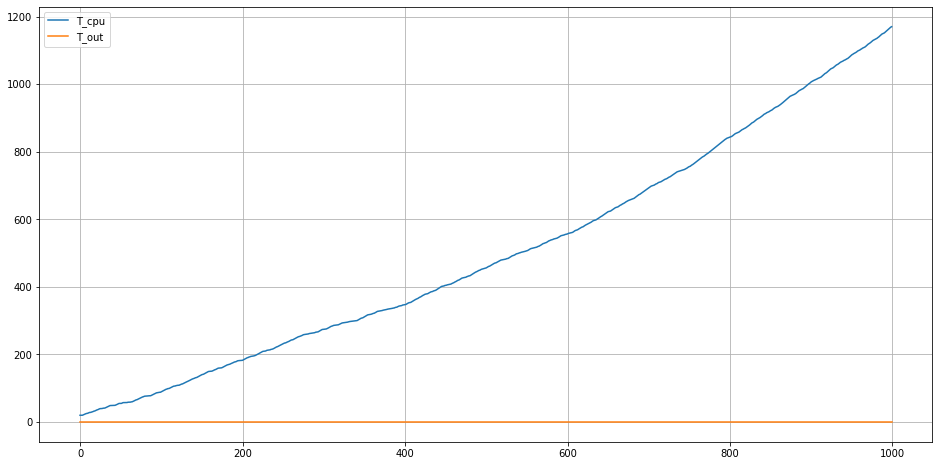

In [28]:
t_sim =  1000  # [min]

#T_model = datacenter_model(t_sim, initial_month = 0, initial_number_users = 10, initial_rate_data = 60)
T_model = rack_model(t_sim, initial_month = 0, initial_number_users = 10, initial_rate_data = 60)

plt.figure(figsize=(16,8))
plt.plot(T_model[:1000,0], label='T_cpu')
plt.plot(T_model[:1000,1], label='T_out')
plt.grid(True)
plt.legend()
plt.show()


### Prepare the series

In [ ]:
# Define a test size
test_size = 50

# Create train and test sets
train_set = T_model[:-test_size]
test_set = T_model[-test_size:]

# Normalize the data (to improve training)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
train_norm = scaler.fit_transform(train_set.reshape(-1,1))

### Prepare data for LSTM
list of tuples: [ (window_i, label_i) ]

In [ ]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size 
window_size = 50   # [min] 

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)


### Define the model
LSTM layer of size (1,100).

In [ ]:
class LSTMnetwork(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=100,num_layers=1,output_size=1):
        # input_size –-> The number of expected features in the input x<i>
        # hidden_size --> The number of features in the hidden state h<i-1>
        # num_layers –-> Number of recurrent layers.
        
        # initalize the nn-Module
        super().__init__()
        
        # set the attribute hidden_size
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size, num_layers)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

        
    def forward(self,seq):
        
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        
        return pred[-1]  # we only want the last value

In [ ]:
# create the model
model = LSTMnetwork()

# define the loss function
criterion = nn.MSELoss() 

# define the optimization function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

### Train the model

In [ ]:
epochs = 100

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # prediction
        y_pred = model(seq)
        
        # loss
        loss = criterion(y_pred, y_train)
        
        # compute gradients
        loss.backward()
        
        # backpropagation (optimizer step)
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')

# Model validation
evaluating the model in the test set

In [ ]:
# initialize the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(test_size):
    
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        
        # initialize the states
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # compute the prediction
        preds.append(model(seq).item())

        
# invert the normalization
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))


# Plot the results

In [ ]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(true_predictions)
plt.plot(test_set)
plt.show()